
===== ADF TEST - Raw Prices =====
ADF Statistic : -1.3984418603936264
p-value : 0.5830228818509386
# Lags Used : 16
# Observations : 953
=> The series is NOT stationary.

===== ADF TEST - First Difference =====
ADF Statistic : -15.424392322525499
p-value : 3.005213726786704e-28
# Lags Used : 15
# Observations : 947
=> The series is STATIONARY.


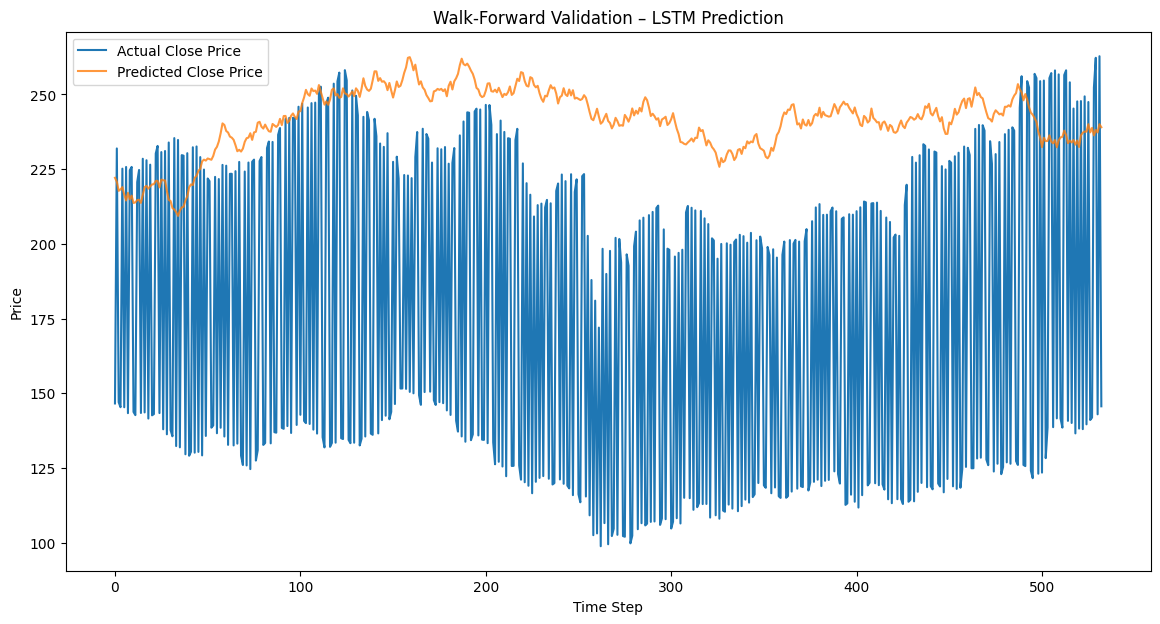

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# ===============================================================
# 1. LOAD DATA
# ===============================================================
# Replace with your CSV or Excel file
df = pd.read_excel("/content/A_AAPL_two_years.xlsx")

# Use only the 'Close' price
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")
prices = df['Close'].values.reshape(-1, 1)


# ===============================================================
# 2. ADF TEST FUNCTION (Stationarity Check)
# ===============================================================
def adf_test(series, title="ADF Test"):
    print(f"\n===== {title} =====")
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f"{label} : {value}")

    if result[1] <= 0.05:
        print("=> The series is STATIONARY.")
    else:
        print("=> The series is NOT stationary.")

# Check raw price stationarity
adf_test(prices, "ADF TEST - Raw Prices")


# ===============================================================
# 3. DIFFERENCING TO MAKE SERIES STATIONARY
# ===============================================================
df['Diff'] = df['Close'].diff()
df.dropna(inplace=True)

differenced_prices = df['Diff'].values.reshape(-1, 1)

# Check stationarity after differencing
adf_test(differenced_prices, "ADF TEST - First Difference")


# ===============================================================
# 4. SCALING
# ===============================================================
# Normalization
minmax = MinMaxScaler()
norm_data = minmax.fit_transform(differenced_prices)

# Standardization
standard = StandardScaler()
std_data = standard.fit_transform(differenced_prices)

# Choose STANDARDIZED DATA for LSTM
data = std_data


# ===============================================================
# 5. CREATE SEQUENCES FOR LSTM
# ===============================================================
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 30  # window size

X_all, y_all = create_sequences(data, SEQ_LEN)

# Convert to PyTorch
X_all = torch.tensor(X_all, dtype=torch.float32)
y_all = torch.tensor(y_all, dtype=torch.float32)


# ===============================================================
# 6. DEFINE LSTM MODEL
# ===============================================================
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=50,
            num_layers=2,
            batch_first=True
        )
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


# ===============================================================
# 7. WALK-FORWARD VALIDATION
# ===============================================================
predictions = []

window_size = 400  # initial training size

for i in range(window_size, len(X_all)):

    # Training window
    X_train = X_all[i - window_size:i]
    y_train = y_all[i - window_size:i]

    model = LSTMModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train for few epochs per step (walk-forward is expensive)
    for epoch in range(10):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    # Predict the next step
    model.eval()
    with torch.no_grad():
        pred = model(X_all[i].unsqueeze(0)).item()
        predictions.append(pred)


# ===============================================================
# 8. INVERSE TRANSFORM THE PREDICTIONS
# ===============================================================
predictions = np.array(predictions).reshape(-1, 1)

# Reverse StandardScaler → remove standardization
inversed_preds = standard.inverse_transform(predictions)

# Now reconstruct original price level:
# price_t = price_(t-1) + diff_prediction
reconstructed_price = []

last_price = df['Close'].iloc[window_size]

for diff in inversed_preds:
    next_price = last_price + diff[0]
    reconstructed_price.append(next_price)
    last_price = next_price


# ===============================================================
# 9. ALIGN REAL VALUES
# ===============================================================
actual_prices = df['Close'].values[window_size + SEQ_LEN:window_size + SEQ_LEN + len(reconstructed_price)]


# ===============================================================
# 10. PLOT RESULTS
# ===============================================================
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label="Actual Close Price")
plt.plot(reconstructed_price, label="Predicted Close Price", alpha=0.8)
plt.title("Walk-Forward Validation – LSTM Prediction")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()
